In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, load_npz, save_npz, vstack
import seaborn as sns
import matplotlib.pyplot as plt
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
import anndata
import scanpy as sc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
See here https://stackoverflow.com/questions/52371329/fast-spearman-correlation-between-two-pandas-dataframes

Calculate correlation between two matrix, row by row
"""

from numba import njit
import numpy as np


@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape

    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)


def chunk_corr(dmr_data, gene_data, mask, cutoff):
    record = corr(a=dmr_data, b=gene_data)
    record[np.abs(record) < cutoff] = 0
    pass_record = csr_matrix(record)
    masked_pass_record = pass_record.multiply(mask)
    return masked_pass_record

In [3]:
chrom = 'chr19'
chunk_size = 1000
cpu = 40
mask_dir = '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/GeneDMRDistanceMask/'
dmr_rate_dir = '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/DMRRate/'
gene_rate_dir = '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/GeneRate/'
output_dir = '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/'
# generate null
dmr_sample = 5000
repeat = 200

# sig corr
neg_logp_cutoff = 3

In [4]:
# Parameters
chunk_size = 1000
cpu = 40
mask_dir = "/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/GeneDMRDistanceMask/"
dmr_rate_dir = "/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/DMRRate/"
gene_rate_dir = "/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/GeneRate/"
output_dir = "/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/gene_dmr_corr/"
dmr_sample = 5000
repeat = 200
neg_logp_cutoff = 3
chrom = "chr1"


## Load Data

In [5]:
dmr_df = pd.read_msgpack(
    f'{dmr_rate_dir}/SubDMR_rate_no_na.{chrom}.msg'
)
gene_df = pd.read_msgpack(
    f'{gene_rate_dir}/gene_rate_no_na.{chrom}.msg'
)
dist_mask = anndata.read_h5ad(
    f'{mask_dir}/{chrom}.h5ad').T


# reindex gene_df, dmr_df
gene_df = gene_df.loc[dist_mask.var_names].copy()
dmr_df = dmr_df.loc[dist_mask.obs_names].copy()

use_cols = dmr_df.columns & gene_df.columns
dmr_df = dmr_df[use_cols].copy()
gene_df = gene_df[use_cols].copy()

In [6]:
cluster_mcg = pd.read_csv(
    f'{output_dir}/ClusterGlobalmCG.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]
cluster_mch = pd.read_csv(
    f'{output_dir}/ClusterGlobalmCH.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]

# standardize global
cluster_mcg = (cluster_mcg - cluster_mcg.mean()) / cluster_mcg.std()
cluster_mch = (cluster_mch - cluster_mch.mean()) / cluster_mch.std()

print(dmr_df.shape[0], 'DMRs')
print(gene_df.shape[0], 'Genes')

120447 DMRs
3447 Genes


## Regress Out DMR global corr
- Global mCH
- Global mCG

In [7]:
dmr_adata = anndata.AnnData(X=dmr_df.values.T,
                obs=pd.DataFrame([], index=dmr_df.columns),
                var=pd.DataFrame([], index=dmr_df.index))

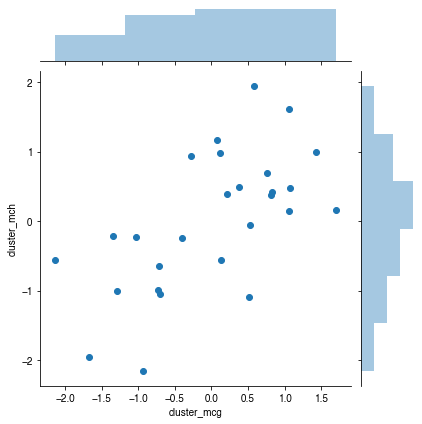

In [8]:
dmr_adata.obs['cluster_mch'] = cluster_mch
dmr_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=dmr_adata.obs['cluster_mcg'], y=dmr_adata.obs['cluster_mch'])

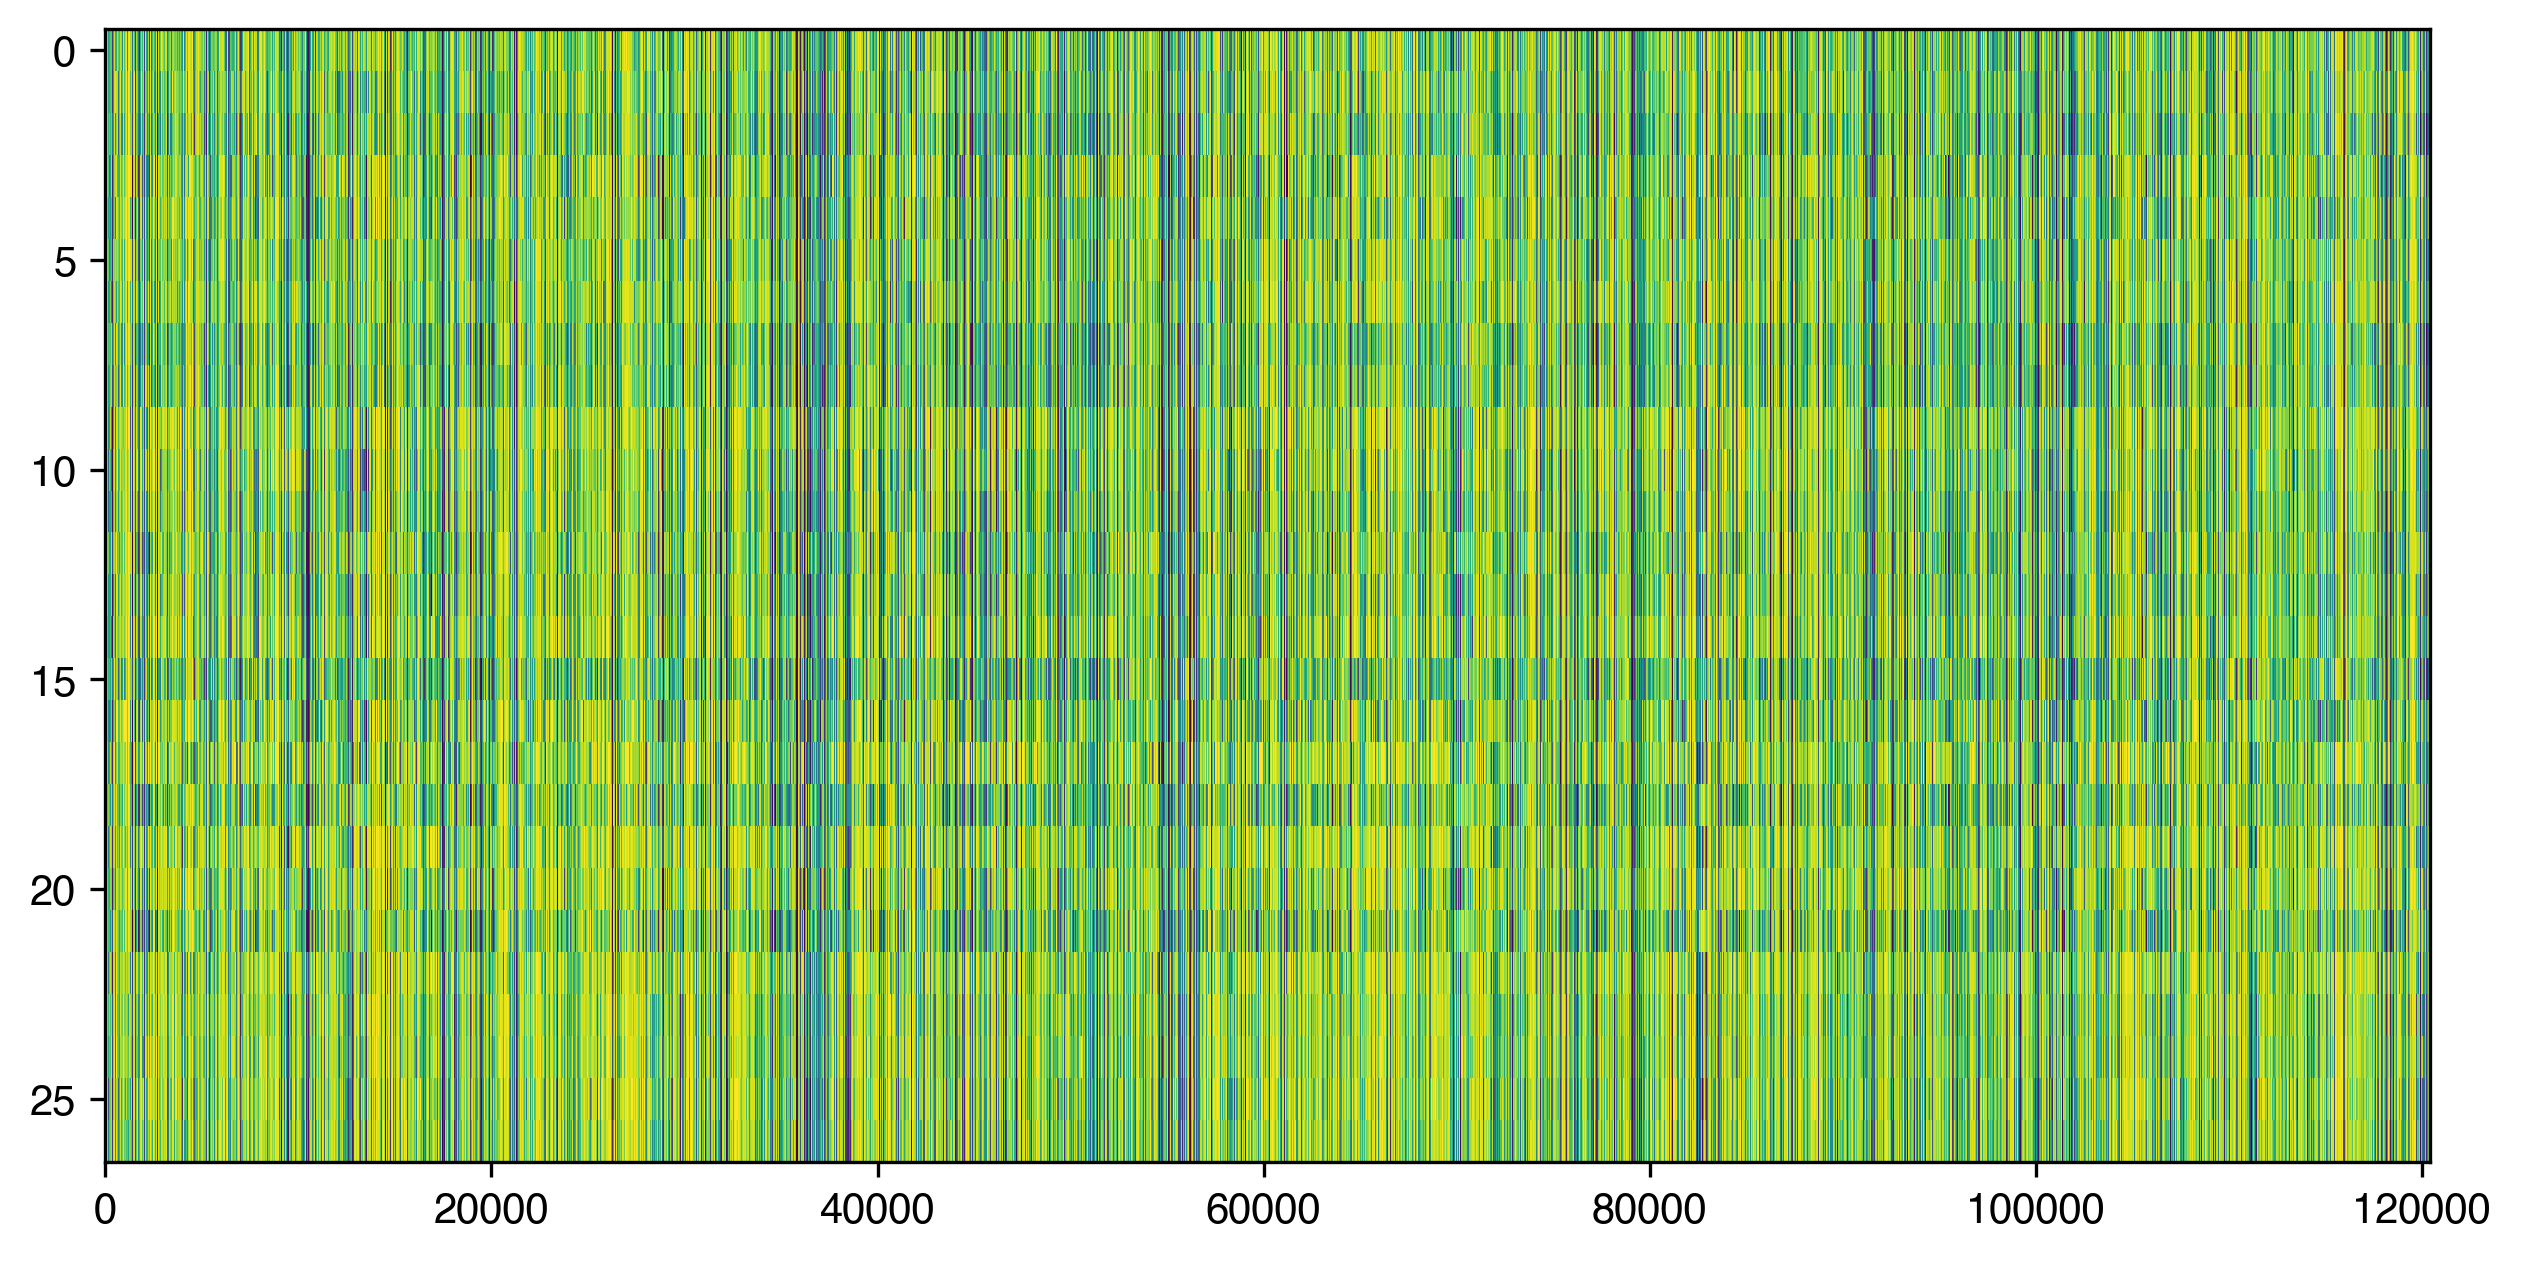

In [9]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', vmin=0, vmax=1)

In [10]:
# remove dmr that has 0 std
# otherwise regress out will fail.
dmr_adata = dmr_adata[:, dmr_adata.X.std(axis=0) > 0].copy()

# since this may change the shape of dmr_adata, reindex mask as well
dist_mask = dist_mask[dmr_adata.X.std(axis=0) > 0, :]

In [11]:
sc.pp.regress_out(dmr_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)

In [12]:
scaler = StandardScaler(copy=False)
dmr_adata.X = scaler.fit_transform(dmr_adata.X)

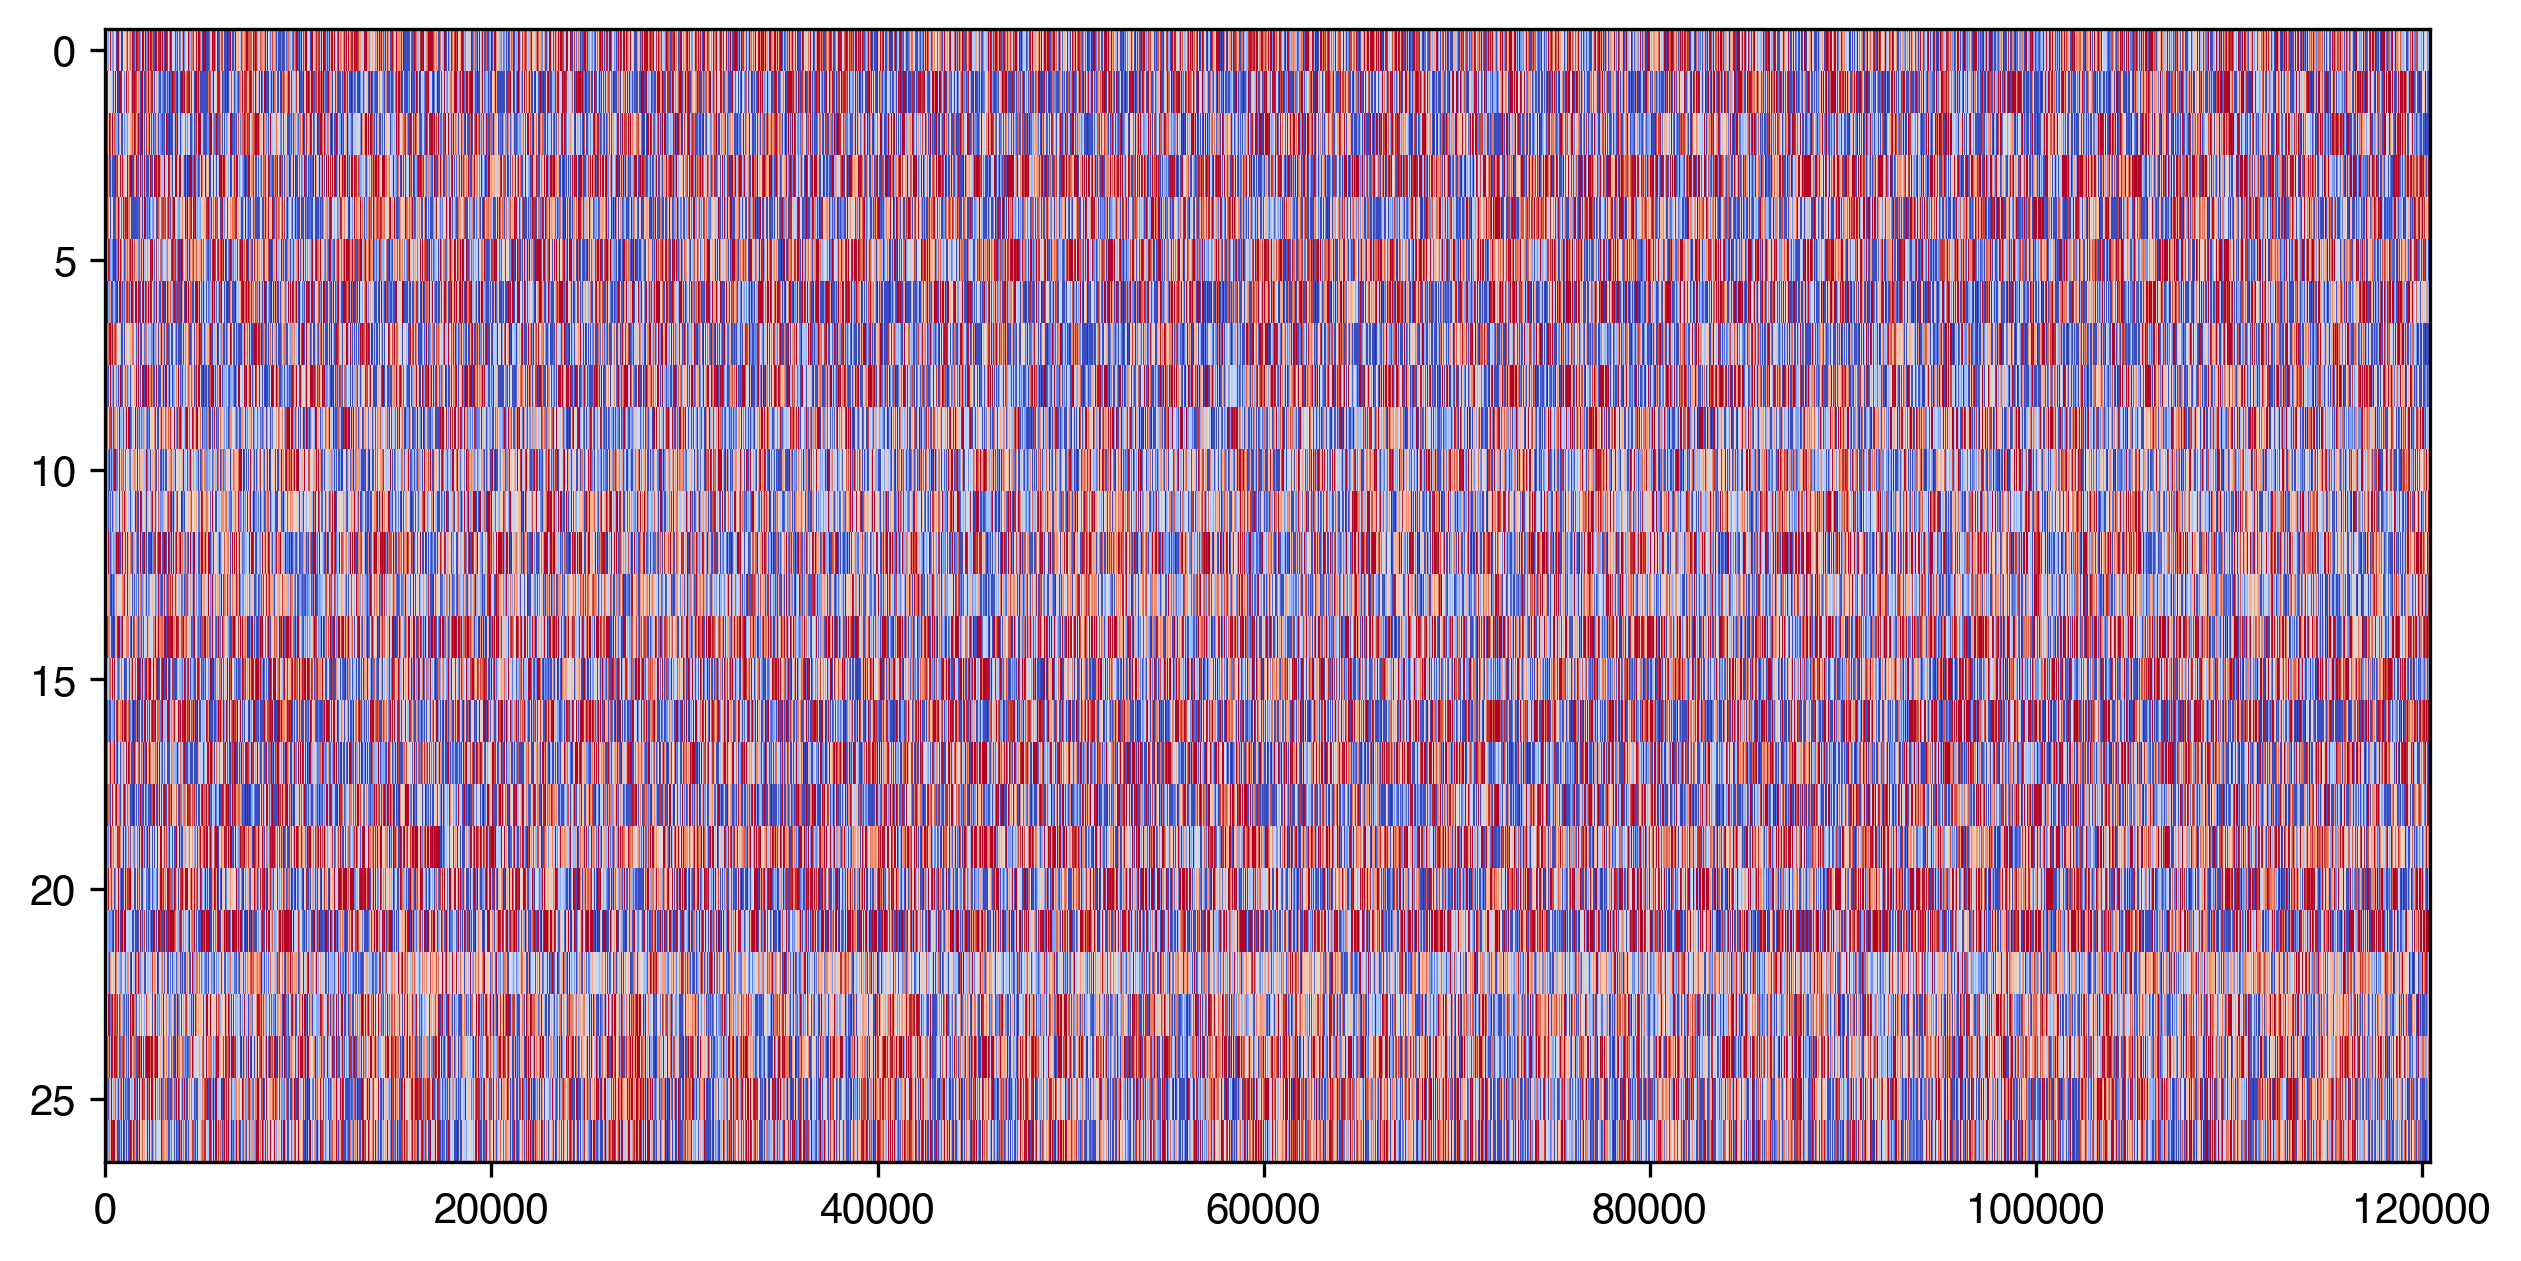

In [13]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', cmap='coolwarm', 
           vmin=-1, vmax=1)

## Regress Out Gene Global Corr

In [14]:
gene_adata = anndata.AnnData(X=gene_df.values.T,
                obs=pd.DataFrame([], index=gene_df.columns),
                var=pd.DataFrame([], index=gene_df.index))

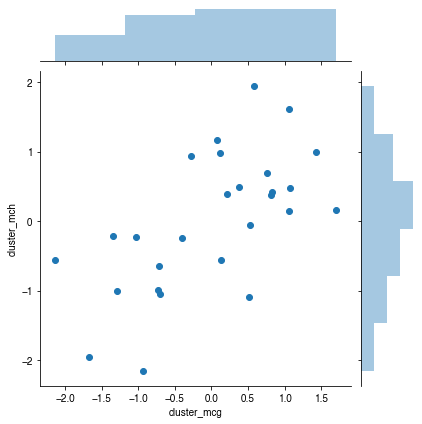

In [15]:
gene_adata.obs['cluster_mch'] = cluster_mch
gene_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=gene_adata.obs['cluster_mcg'], 
              y=gene_adata.obs['cluster_mch'])

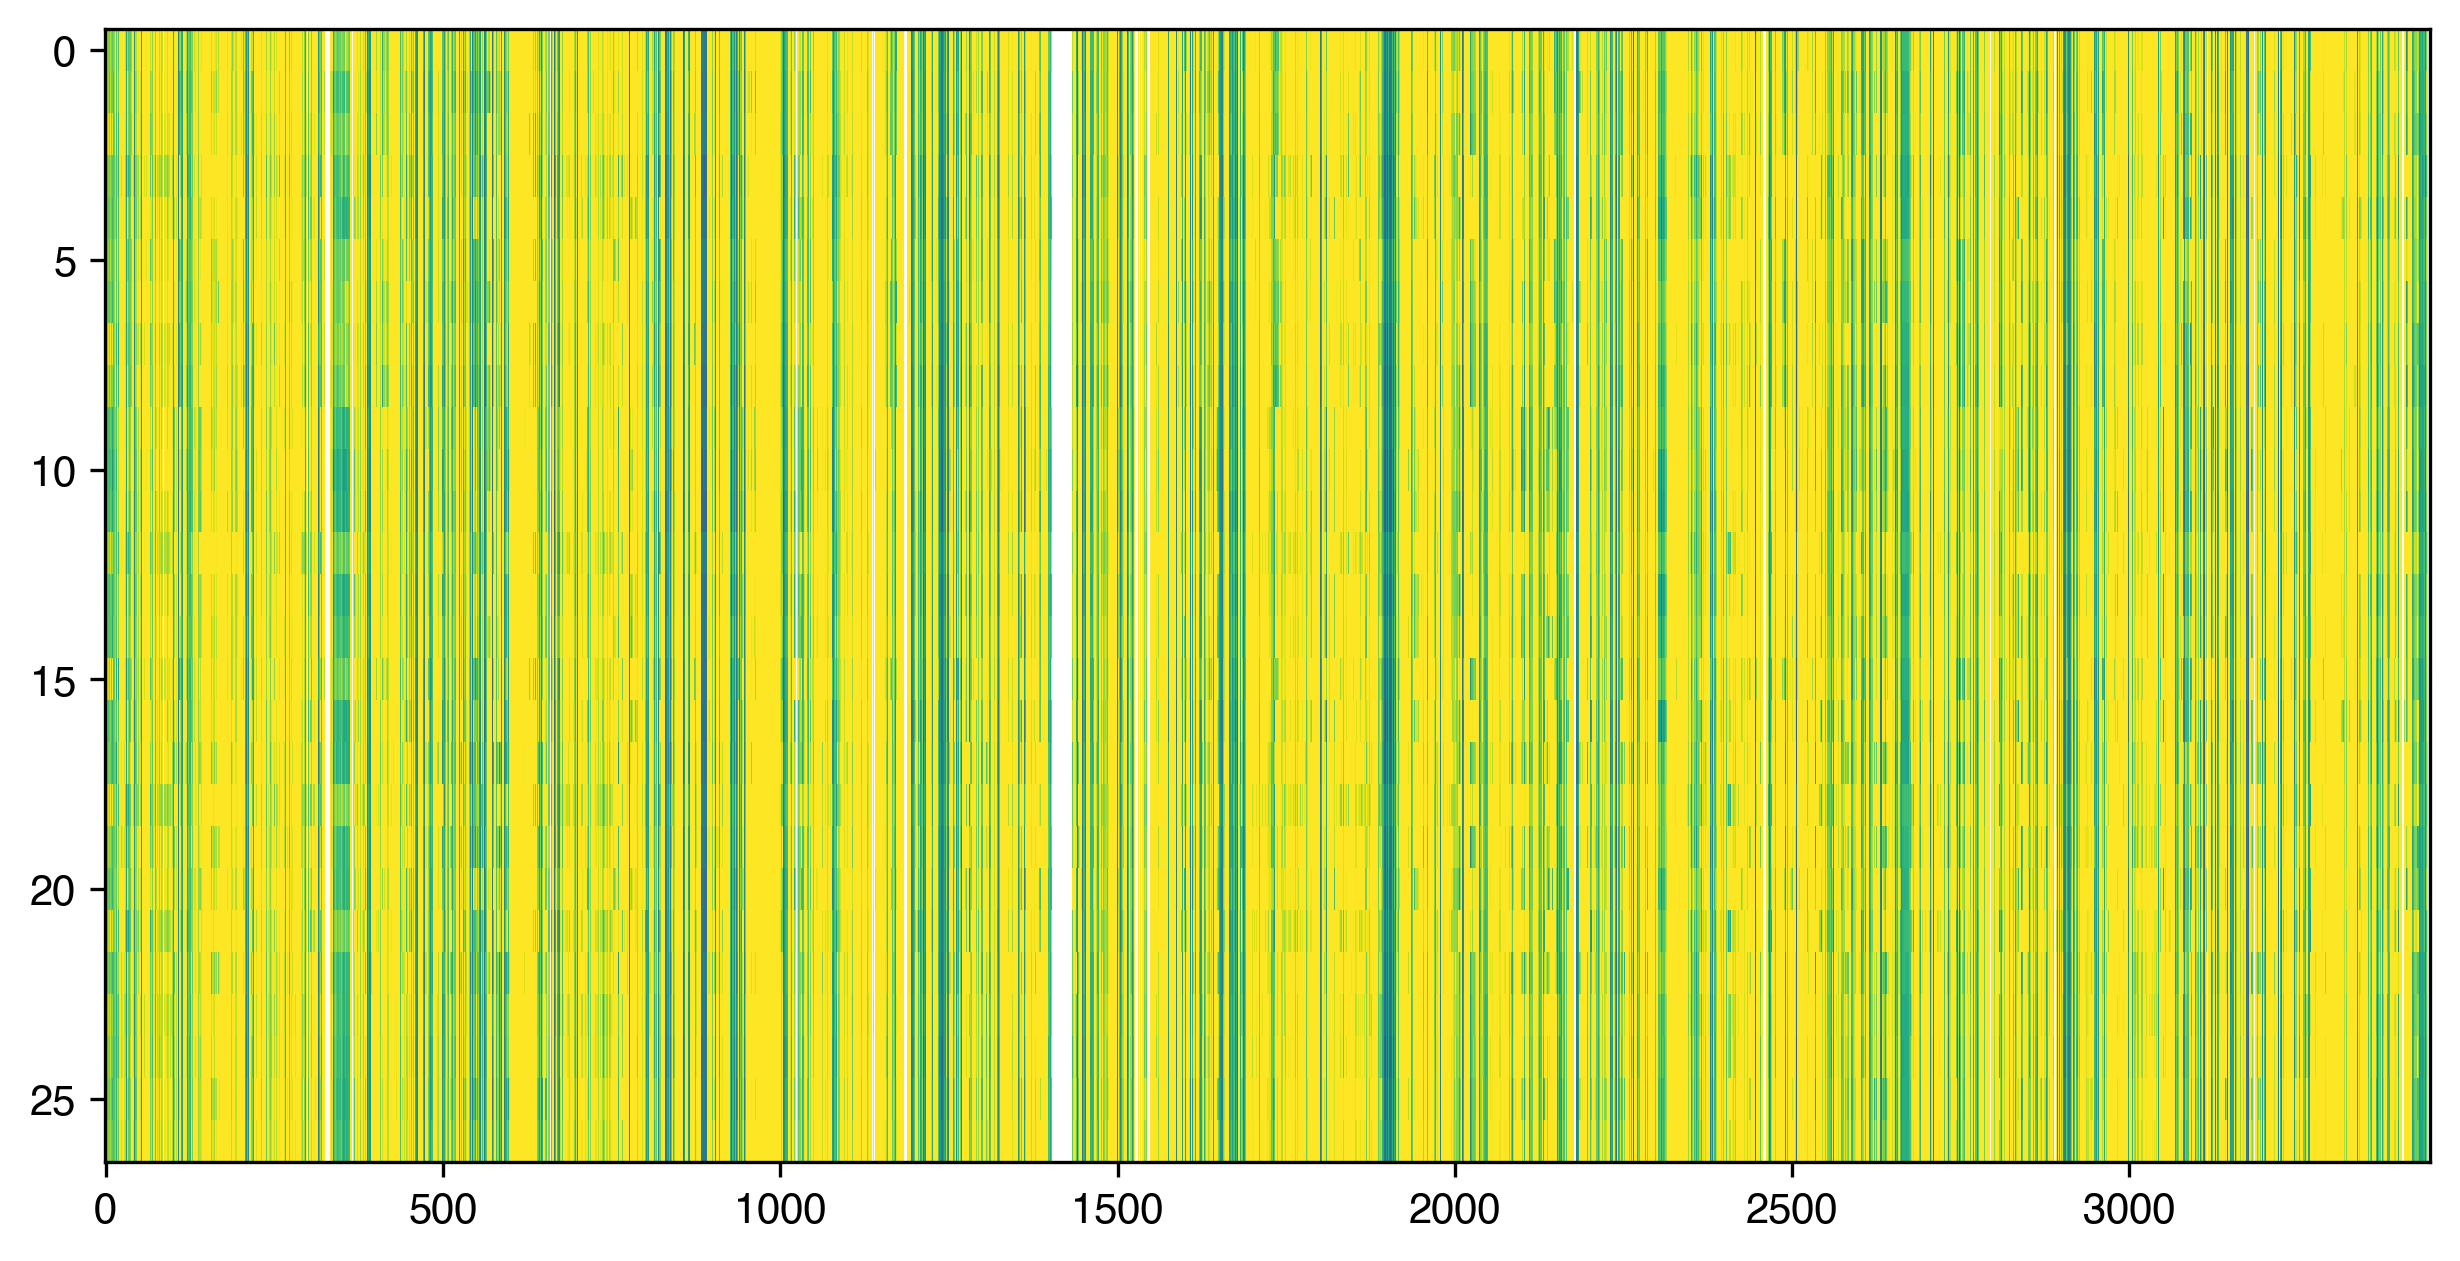

In [16]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(gene_adata.X, aspect='auto', vmin=0, vmax=1)

In [17]:
# remove dmr that has 0 std
# otherwise regress out will fail.
judge = gene_adata.X.std(axis=0) > 0
gene_adata = gene_adata[:, judge].copy()

# since this may change the shape of dmr_adata, reindex mask as well
dist_mask = dist_mask[:, judge]

In [18]:
sc.pp.regress_out(gene_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)

In [19]:
scaler = StandardScaler(copy=False)
gene_adata.X = scaler.fit_transform(gene_adata.X)

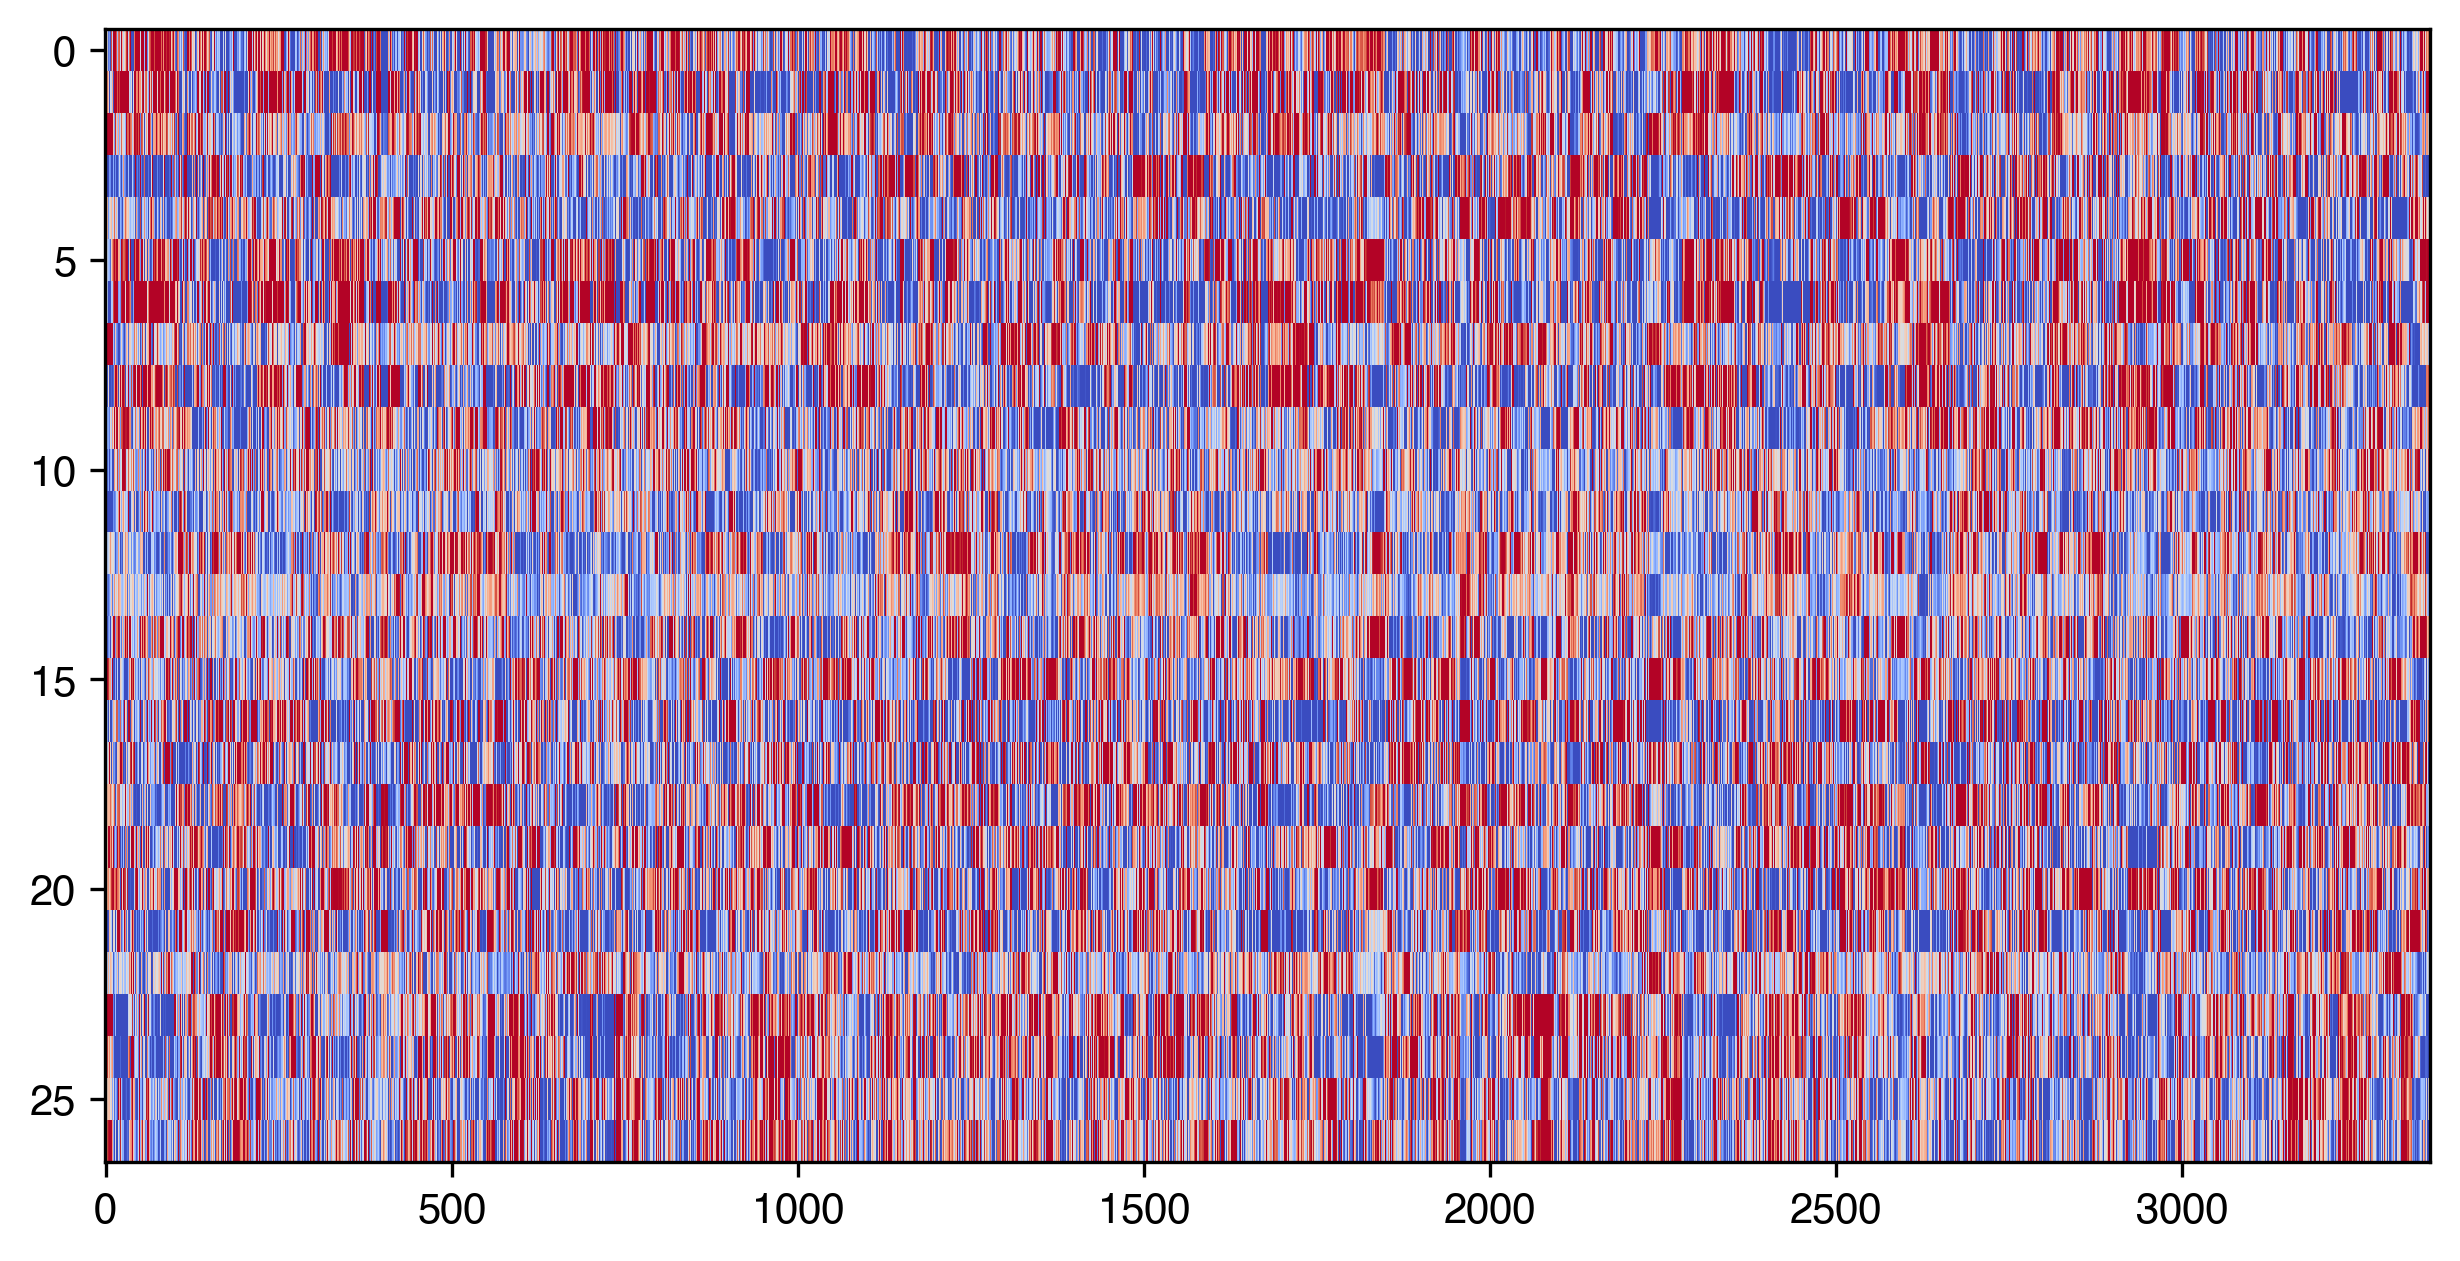

In [20]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(gene_adata.X, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

## Calculate residual Corr

In [21]:
use_dist_mask = dist_mask.X.copy()

In [22]:
gene_data = gene_adata.X.T
total_dmr_data = dmr_adata.X.T

results = []
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, total_dmr_data.shape[0], chunk_size)):
        dmr_data = total_dmr_data[chunk_start:chunk_start+chunk_size, :]
        mask = use_dist_mask[chunk_start:chunk_start+chunk_size, :]
    
        future = executor.submit(chunk_corr,
                                 dmr_data=dmr_data, 
                                 gene_data=gene_data, 
                                 mask=mask,
                                 cutoff=0.2)
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record

# final concat
final_adata = anndata.AnnData(vstack((results[i] for i in range(len(results)))), 
                              obs=dmr_adata.var.copy(), 
                              var=gene_adata.var.copy())
final_adata

AnnData object with n_obs × n_vars = 120447 × 3359 

## Calculate Null Dist

In [23]:
# row is cluster
shuffled_gene_data_T = gene_data.T.copy()
shuffled_dmr_data_T = total_dmr_data.T.copy()

In [24]:
# shuffle axis 0 inplace
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    results = []
    for _ in range(repeat):
        # shuffle axis 0 in each repeat
        np.random.shuffle(shuffled_gene_data_T)
        np.random.shuffle(shuffled_dmr_data_T)
        
        # downsample DMR data, no need to use full DMR list to calc null
        if shuffled_dmr_data_T.shape[1] > dmr_sample:
            indices = np.random.choice(shuffled_dmr_data_T.shape[1], dmr_sample, replace=False)
            this_dmrs = shuffled_dmr_data_T[:, indices]
            this_mask = use_dist_mask[indices, :]
        else:
            this_mask = use_dist_mask
            this_dmrs = shuffled_dmr_data_T
        mask = use_dist_mask[chunk_start:chunk_start+chunk_size, :]
    
        future = executor.submit(chunk_corr,
                                 dmr_data=this_dmrs.T, 
                                 gene_data=shuffled_gene_data_T.T, 
                                 mask=this_mask,
                                 cutoff=0)
        futures[future] = i

    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results.append(masked_pass_record)

# final concat
final_null_result = vstack(results)

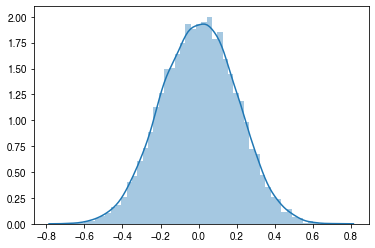

In [25]:
sns.distplot(np.random.choice(final_null_result.data, 10000, replace=False))

In [26]:
p_values = {}
for i in np.arange(0.4, 0.9, 0.005):
    total_n = final_null_result.data.size
    p = (final_null_result > i).sum() / total_n
    p_values[i] = p
p_values = pd.Series(p_values)
p_values = -np.log10(p_values)
p_values.replace(np.inf, 10, inplace=True)

In [27]:
p_values.values

array([ 1.7293055 ,  1.75980774,  1.79087326,  1.82253897,  1.85441646,
        1.88671614,  1.9196016 ,  1.95280666,  1.98663538,  2.02081534,
        2.05558512,  2.09063674,  2.12646955,  2.16263824,  2.19974971,
        2.23717571,  2.27512895,  2.31405298,  2.35360162,  2.39347181,
        2.43356253,  2.47454034,  2.51549522,  2.55728939,  2.59914244,
        2.64212285,  2.6862946 ,  2.73018625,  2.77578856,  2.82161173,
        2.86757079,  2.91511672,  2.96442065,  3.01297428,  3.06184687,
        3.11255675,  3.16270044,  3.21437302,  3.26662401,  3.32223398,
        3.37762026,  3.43289721,  3.48963193,  3.54496605,  3.60403077,
        3.66143519,  3.72198595,  3.78434844,  3.84623296,  3.90719155,
        3.97175135,  4.03731177,  4.10844872,  4.17785857,  4.24778203,
        4.320206  ,  4.3913687 ,  4.46030629,  4.5348993 ,  4.6114657 ,
        4.69212163,  4.76296347,  4.85163787,  4.93807768,  5.02772912,
        5.12254471,  5.18676397,  5.29640308,  5.39891697,  5.49

In [28]:
cutoff = p_values[p_values > neg_logp_cutoff].index[0]
cutoff

0.5650000000000002

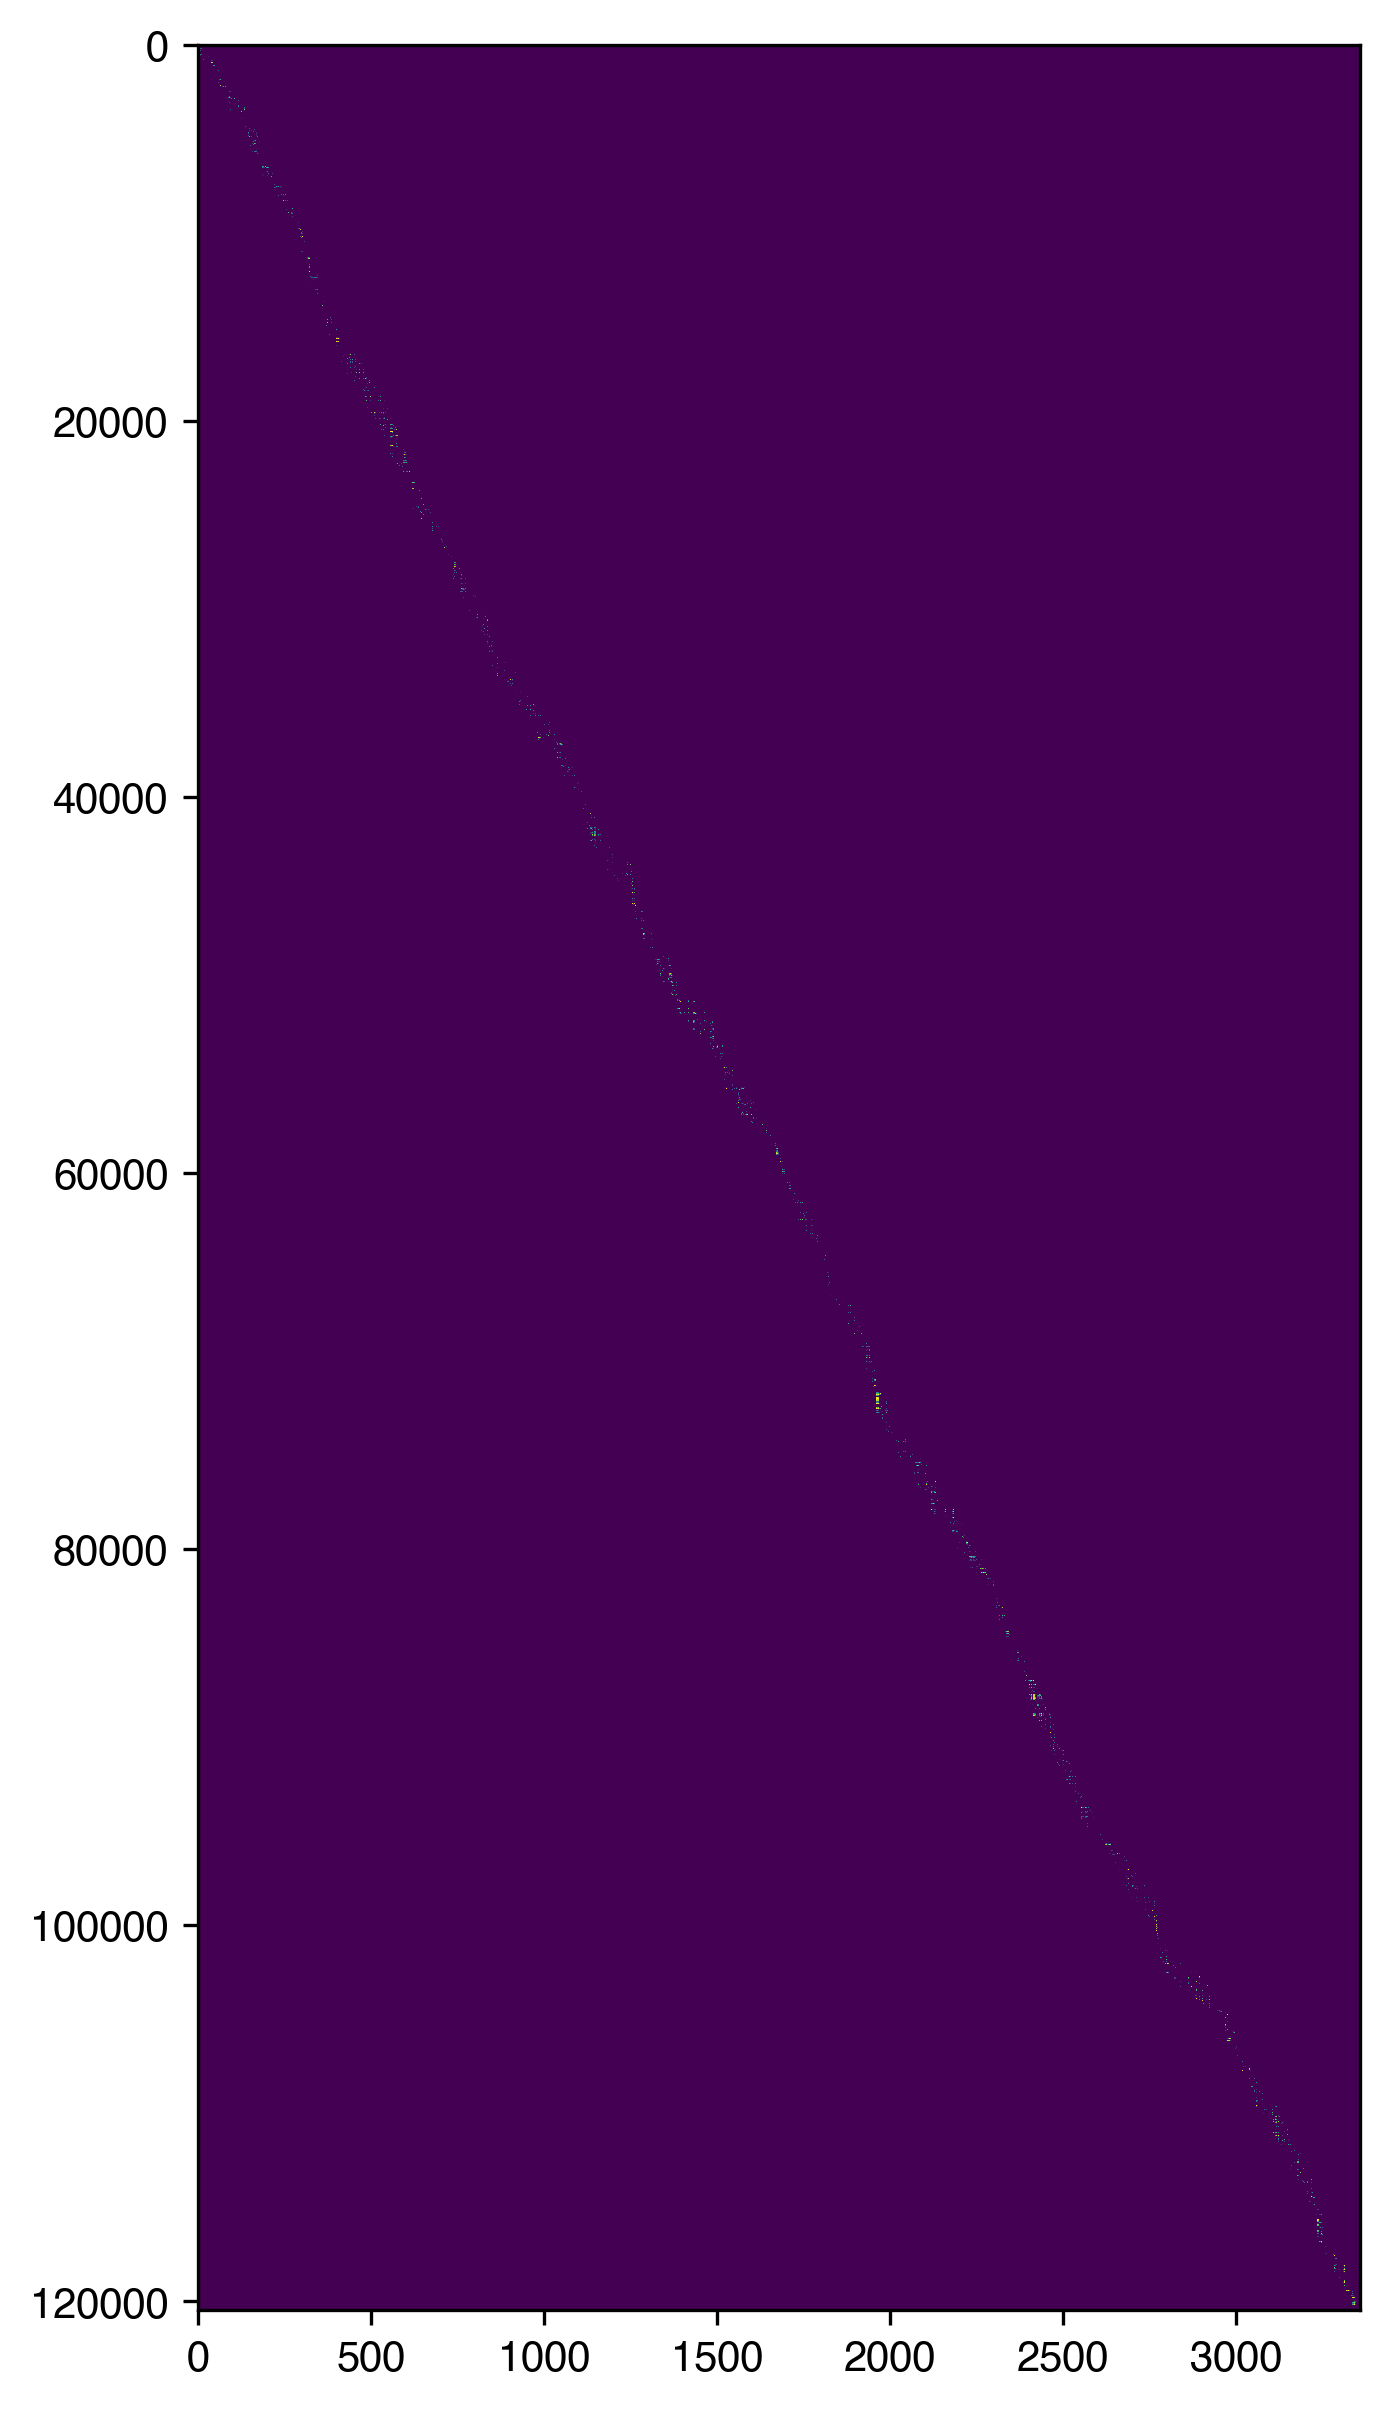

In [29]:
fig = plt.figure(figsize=(5, 10), dpi=300)
plt.imshow(final_adata.X.todense(), cmap='viridis',
           aspect='auto', vmin=cutoff, vmax=min(cutoff + 0.3, 1))

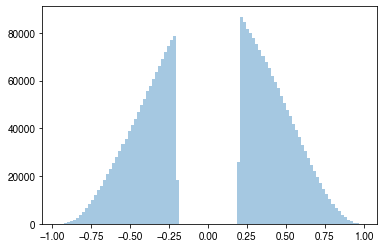

In [30]:
sns.distplot(final_adata.X.data, kde=False, bins=100)

In [31]:
final_adata.X = final_adata.X.multiply(final_adata.X > cutoff)

In [32]:
final_adata.write_h5ad(f'{chrom}.h5ad')

In [33]:
final_adata

AnnData object with n_obs × n_vars = 120447 × 3359 

In [34]:
final_adata.X

<120447x3359 sparse matrix of type '<class 'numpy.float32'>'
	with 302601 stored elements in Compressed Sparse Row format>